In [1]:
import sys
sys.path.append("..")
import src.sim
import src.strategy
import src.clearing
from src.plot import SimulationVisualizer

# Load profiles

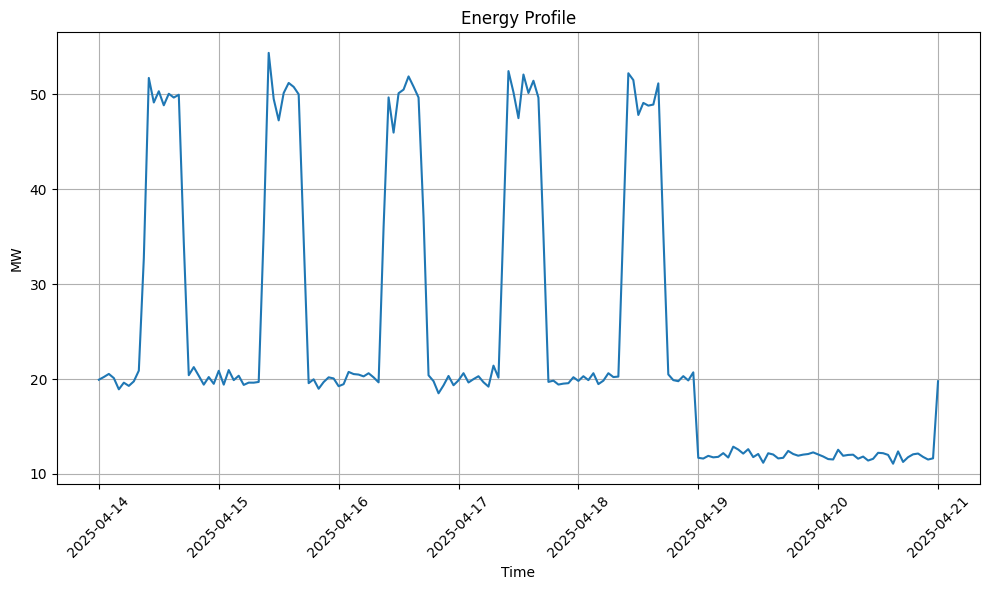

In [2]:
from src.load_profiles import industrial_profile, plot_profile
import datetime

profile = industrial_profile(
    start_time=datetime.datetime(2025, 4, 14, 0, 0),
    end_time=datetime.datetime(2025, 4, 21, 0, 0),
    time_step=datetime.timedelta(minutes=60)
)

plot_profile(profile)

# Load Data

In [3]:
import pandas as pd
trades = pd.read_parquet("../data/synthetic/trades_df.parquet", engine="fastparquet")

In [5]:
trades[trades['contract'] == '2025-04-13 00:00']

,delivery_time,trade_time,trade_hour,price,volume,contract,hours_to_delivery,hourly_vwap,overall_vwap
0,2025-04-13,2025-04-12 15:00:01.073371,2025-04-12 15:00:00,30.43,3.7,2025-04-13 00:00,9.0,46.67,36.69
1,2025-04-13,2025-04-12 15:00:02.566880,2025-04-12 15:00:00,31.44,0.1,2025-04-13 00:00,9.0,46.67,36.69
2,2025-04-13,2025-04-12 15:00:09.919522,2025-04-12 15:00:00,29.27,4.5,2025-04-13 00:00,9.0,46.67,36.69
3,2025-04-13,2025-04-12 15:00:10.537326,2025-04-12 15:00:00,29.56,3.8,2025-04-13 00:00,9.0,46.67,36.69
4,2025-04-13,2025-04-12 15:00:10.961116,2025-04-12 15:00:00,29.45,6.2,2025-04-13 00:00,9.0,46.67,36.69
...,...,...,...,...,...,...,...,...,...
9995,2025-04-13,2025-04-12 23:59:42.586480,2025-04-12 23:00:00,29.21,3.9,2025-04-13 00:00,0.0,39.28,36.69
9996,2025-04-13,2025-04-12 23:59:46.045726,2025-04-12 23:00:00,26.89,3.9,2025-04-13 00:00,0.0,39.28,36.69
9997,2025-04-13,2025-04-12 23:59:47.425738,2025-04-12 23:00:00,28.18,8.3,2025-04-13 00:00,0.0,39.28,36.69
9998,2025-04-13,2025-04-12 23:59:51.681846,2025-04-12 23:00:00,30.23,4.9,2025-04-13 00:00,0.0,39.28,36.69


# Clearing Mechanism

In [68]:
import datetime
from typing import Dict, List, Any
import pandas as pd
from src.clearing import ClearingMechanism

class VwapBasedClearing(ClearingMechanism):
    """Clearing mechanism that uses hourly VWAP from synthetic trades as reference price.
    
    Orders clear if they cross the hourly VWAP for their respective contract
    (buys above, sells below), with execution happening at the VWAP price.
    """
    
    def __init__(self, trades_df: pd.DataFrame):
        """Initialize the VWAP-based clearing.
        
        Args:
            trades_df: DataFrame containing synthetic trades with hourly VWAP values
        """
        super().__init__()
        self.trades_df = trades_df
        # Pre-calculate a lookup dictionary for quick reference
        self._prepare_vwap_lookup()
    
    def _prepare_vwap_lookup(self):
        """Create a fast lookup dictionary for VWAP values."""
        self.vwap_lookup = {}
        
        # Group by contract and trade_hour to get hourly VWAPs
        for (contract, trade_hour), group in self.trades_df.groupby(['contract', 'trade_hour']):
            if 'hourly_vwap' in group.columns:
                # If hourly_vwap is already calculated
                vwap = group['hourly_vwap'].iloc[0]
            else:
                # Calculate VWAP if not present
                vwap = (group['price'] * group['volume']).sum() / group['volume'].sum()
            
            # Store in lookup: {contract: {trade_hour: vwap}}
            if contract not in self.vwap_lookup:
                self.vwap_lookup[contract] = {}
            self.vwap_lookup[contract][trade_hour] = vwap
    
    def get_vwap(self, contract: str, current_time: datetime.datetime) -> float:
        """Get the hourly VWAP for a specific contract and time.
        
        Args:
            contract: Contract identifier (e.g., '2023-06-01 14:00')
            current_time: Current simulation time
            
        Returns:
            Hourly VWAP value for the given contract and time
            
        Raises:
            ValueError: If no VWAP is available for the specified contract and time
        """
        # Round down to the hour
        trade_hour = current_time.replace(minute=0, second=0, microsecond=0)
        
        try:
            print(self.vwap_lookup)
            return self.vwap_lookup[contract][trade_hour]
        except KeyError:
            raise ValueError(f"No VWAP available for contract {contract} at {trade_hour}")
    
    def clear(self, current_time: datetime.datetime, active_orders: Dict[str, Any]) -> List[Any]:
        """Clear orders against hourly VWAP from synthetic trades.
        
        Args:
            current_time: Current simulation time
            active_orders: Dictionary of active orders (order_id -> Order)
            
        Returns:
            List of orders that were filled/executed in this clearing
        """
        cleared_orders = []
        
        # Group orders by contract
        orders_by_contract = {}
        for order_id, order in active_orders.items():
            # Convert contract_time to contract string format
            contract = order.contract_time.strftime('%Y-%m-%d %H:00')
            if contract not in orders_by_contract:
                orders_by_contract[contract] = []
            orders_by_contract[contract].append(order)
        
        # Process orders for each contract
        for contract, orders in orders_by_contract.items():
            try:
                # Get hourly VWAP for this contract
                vwap_price = self.get_vwap(contract, current_time)
                
                # Check each order against the VWAP
                for order in orders:
                    if order.side == 'buy' and order.price >= vwap_price:
                        # Buy order clears if price is at or above VWAP
                        order.execution_price = vwap_price
                        order.execution_time = current_time
                        cleared_orders.append(order)
                        
                    elif order.side == 'sell' and order.price <= vwap_price:
                        # Sell order clears if price is at or below VWAP
                        order.execution_price = vwap_price
                        order.execution_time = current_time
                        cleared_orders.append(order)
                        
            except ValueError as e:
                # Handle case where no VWAP is available
                print(f"No VWAP available for {contract} at {current_time}: {e}")
                continue
        
        return cleared_orders

In [69]:
import datetime
from typing import Dict, List, Any
import pandas as pd
from src.clearing import ClearingMechanism

class ContractVwapClearing(ClearingMechanism):
    """Clearing mechanism that uses overall contract VWAP from synthetic trades as reference price.
    
    Orders clear if they cross the contract's overall VWAP 
    (buys above, sells below), with execution happening at the VWAP price.
    """
    
    def __init__(self, trades_df: pd.DataFrame):
        """Initialize the contract VWAP-based clearing.
        
        Args:
            trades_df: DataFrame containing synthetic trades
        """
        super().__init__()
        self.trades_df = trades_df
        # Pre-calculate a lookup dictionary for quick reference
        self._prepare_vwap_lookup()
    
    def _prepare_vwap_lookup(self):
        """Create a fast lookup dictionary for overall contract VWAP values."""
        self.vwap_lookup = {}
        
        # Group by contract to get overall VWAPs
        for contract, group in self.trades_df.groupby('contract'):
            if 'overall_vwap' in group.columns:
                # If overall_vwap is already calculated
                vwap = group['overall_vwap'].iloc[0]
            else:
                # Calculate VWAP if not present
                vwap = (group['price'] * group['volume']).sum() / group['volume'].sum()
            
            # Store in lookup: {contract: vwap}
            self.vwap_lookup[contract] = vwap
    
    def get_vwap(self, contract: str) -> float:
        """Get the overall VWAP for a specific contract.
        
        Args:
            contract: Contract identifier (e.g., '2023-06-01 14:00')
            
        Returns:
            Overall VWAP value for the given contract
            
        Raises:
            ValueError: If no VWAP is available for the specified contract
        """
        try:
            return self.vwap_lookup[contract]
        except KeyError:
            raise ValueError(f"No VWAP available for contract {contract}")
    
    def clear(self, current_time: datetime.datetime, active_orders: Dict[str, Any]) -> List[Any]:
        """Clear orders against overall contract VWAP from synthetic trades.
        
        Args:
            current_time: Current simulation time
            active_orders: Dictionary of active orders (order_id -> Order)
            
        Returns:
            List of orders that were filled/executed in this clearing
        """
        cleared_orders = []
        
        # Group orders by contract
        orders_by_contract = {}
        for order_id, order in active_orders.items():
            # Convert contract_time to contract string format
            contract = order.contract_time.strftime('%Y-%m-%d %H:00')
            if contract not in orders_by_contract:
                orders_by_contract[contract] = []
            orders_by_contract[contract].append(order)
        
        # Process orders for each contract
        for contract, orders in orders_by_contract.items():
            try:
                # Get overall VWAP for this contract
                vwap_price = self.get_vwap(contract)
                
                # Check each order against the VWAP
                for order in orders:
                    if order.side == 'buy' and order.price >= vwap_price:
                        # Buy order clears if price is at or above VWAP
                        order.execution_price = vwap_price
                        order.execution_time = current_time
                        cleared_orders.append(order)
                        
                    elif order.side == 'sell' and order.price <= vwap_price:
                        # Sell order clears if price is at or below VWAP
                        order.execution_price = vwap_price
                        order.execution_time = current_time
                        cleared_orders.append(order)
                        
            except ValueError as e:
                # Handle case where no VWAP is available
                print(f"No VWAP available for {contract}: {e}")
                continue
        
        return cleared_orders

In [70]:
import datetime
from typing import Dict, List, Any
import pandas as pd
from src.clearing import ClearingMechanism

class VolumeBasedClearing(ClearingMechanism):
    """Clearing mechanism that executes orders when sufficient volume has been traded.
    
    An order clears when a specified multiple of its volume has been traded at or beyond
    its price level since the order was placed. For buy orders, we check volume traded
    at or below the order price. For sell orders, we check volume traded at or above.
    """
    
    def __init__(self, trades_df: pd.DataFrame, volume_multiplier: float = 3.0):
        """Initialize the volume-based clearing.
        
        Args:
            trades_df: DataFrame containing synthetic trades
            volume_multiplier: How many times the order volume needs to be traded
                               at favorable prices before execution (default: 3.0)
        """
        super().__init__()
        self.trades_df = trades_df
        self.volume_multiplier = volume_multiplier
        # Prepare trades for efficient lookup
        self._prepare_trades_lookup()
    
    def _prepare_trades_lookup(self):
        """Create a lookup structure for trades by contract."""
        # Group trades by contract
        self.trades_by_contract = {}
        for contract, group in self.trades_df.groupby('contract'):
            # Sort trades by trade_time to ensure chronological processing
            self.trades_by_contract[contract] = group.sort_values('trade_time')
    
    def check_volume_condition(self, order: Any, contract: str, current_time: datetime.datetime) -> bool:
        """Check if enough volume has been traded to execute this order.
        
        Args:
            order: The order to check
            contract: Contract string identifier
            current_time: Current simulation time
            
        Returns:
            True if the volume condition is met, False otherwise
        """
        order_time = order.submission_time
        order_price = order.price
        order_quantity = order.quantity
        
        # If we don't have trades for this contract, condition can't be met
        if contract not in self.trades_by_contract:
            return False
            
        # If order has no submission time, we can't determine relevant trades
        if order_time is None:
            return False
        
        # Get trades for this contract
        contract_trades = self.trades_by_contract[contract]
        
        # Filter trades that happened after the order was placed but before current time
        relevant_trades = contract_trades[
            (contract_trades['trade_time'] > order_time) & 
            (contract_trades['trade_time'] <= current_time)
        ]
        
        if order.side == 'buy':
            # For buy orders, count volume traded at or below the order price
            matching_trades = relevant_trades[relevant_trades['price'] <= order_price]
        else:  # sell
            # For sell orders, count volume traded at or above the order price
            matching_trades = relevant_trades[relevant_trades['price'] >= order_price]
        
        # Sum up the relevant traded volume
        traded_volume = matching_trades['volume'].sum()
        
        # Check if traded volume exceeds the required multiple of order quantity
        return traded_volume >= (order_quantity * self.volume_multiplier)
    
    def calculate_execution_price(self, order: Any, contract: str, current_time: datetime.datetime) -> float:
        """Calculate the execution price for an order that meets volume conditions.
        
        Uses the VWAP of qualifying trades as the execution price.
        
        Args:
            order: The order to calculate price for
            contract: Contract string identifier
            current_time: Current simulation time
            
        Returns:
            VWAP of trades that qualified the order for execution
        """
        order_time = order.submission_time
        order_price = order.price
        
        # If order has no submission time, use the order price
        if order_time is None:
            return order_price
        
        # Get trades for this contract
        contract_trades = self.trades_by_contract[contract]
        
        # Filter trades that happened after the order was placed but before current time
        relevant_trades = contract_trades[
            (contract_trades['trade_time'] > order_time) & 
            (contract_trades['trade_time'] <= current_time)
        ]
        
        if order.side == 'buy':
            # For buy orders, use trades at or below the order price
            matching_trades = relevant_trades[relevant_trades['price'] <= order_price]
        else:  # sell
            # For sell orders, use trades at or above the order price
            matching_trades = relevant_trades[relevant_trades['price'] >= order_price]
        
        # Calculate VWAP of matching trades
        if len(matching_trades) > 0:
            vwap = (matching_trades['price'] * matching_trades['volume']).sum() / matching_trades['volume'].sum()
            return round(vwap, 2)
        else:
            # Fallback to order price if no matching trades
            return order_price
    
    def clear(self, current_time: datetime.datetime, active_orders: Dict[str, Any]) -> List[Any]:
        """Clear orders based on traded volume conditions.
        
        Args:
            current_time: Current simulation time
            active_orders: Dictionary of active orders (order_id -> Order)
            
        Returns:
            List of orders that were filled/executed in this clearing
        """
        cleared_orders = []
        
        # Check each order to see if enough volume has been traded
        for order_id, order in active_orders.items():
            # Convert contract_time to contract string format
            contract = order.contract_time.strftime('%Y-%m-%d %H:00')
            
            # Skip if contract doesn't exist in our data
            if contract not in self.trades_by_contract:
                continue
                
            # Check if the volume condition is met
            if self.check_volume_condition(order, contract, current_time):
                # Calculate execution price based on matching trades
                execution_price = self.calculate_execution_price(order, contract, current_time)
                
                # Execute the order
                order.execution_price = execution_price
                order.execution_time = current_time
                cleared_orders.append(order)
        
        return cleared_orders

In [71]:
vwapclearing = VwapBasedClearing(trades)

In [72]:
contract_vwap_clearing = ContractVwapClearing(trades)

In [73]:
volume_clearing = VolumeBasedClearing(trades)

# Strat - START EHIMARAE CODE

Mean Absolute Percentage Error: 5.223972669383955%


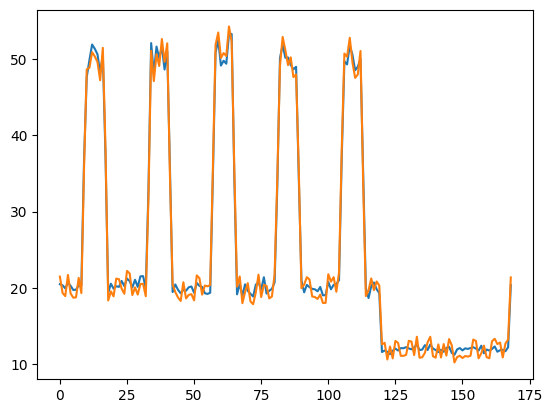

In [90]:
import matplotlib.pyplot as plt
import numpy as np
import random

plt.plot(profile['value'].values)

def create_noisy_data(original_data, target_mape=0.05):
        # Heuristic
        noise_magnitude = target_mape*np.median(original_data)

        noisy_data = []
        for i in original_data:
            flip = random.random()
            multiplier = -1 if flip < 0.5 else 1
            noisy_data.append(i + multiplier*noise_magnitude)
        
        # MAPE
        sum_mape = 0
        N = len(original_data)
        for i in range(0, N):
            orig = original_data[i]
            noisy = noisy_data[i]
            if orig == 0:
                continue
            percentage_error = abs(orig - noisy) / orig
            sum_mape += percentage_error
        mape_error = sum_mape / N
        print('Mean Absolute Percentage Error: {}%'.format(mape_error*100))

        return noisy_data

noise = create_noisy_data(profile['value'].values, target_mape=0.05)
plt.plot(noise)

In [ ]:
import datetime
import uuid
import random
from typing import List, Dict, Tuple, Any, Optional
from abc import ABC, abstractmethod
from src.sim import Order
from src.strategy import Strategy
from src.data import DataSource
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

class PriceForecastingBasedStrategy(Strategy):
    """TODO
    
    Write  a description.
    """
    
    def __init__(self, 
                 load_profile: pd.DataFrame,
                 data_source: DataSource,
                 clearing_mechanism: ClearingMechanism,
                 strategy_id: Optional[str] = None,
                 forecast_horizon: int = 12,  # Forecast horizon in hours
                 forecast_error: float = 0.05): # Forecast error (MAPE)
        """Initialize the price forecasting-based strategy.
        
        Args:
            load_profile: DataFrame with timestamp and value columns
            data_sources: Optional list of data sources for price information
            clearing_mechanism: Clearing mechanism from which we can get the VWAP.
            strategy_id: Unique identifier for this strategy instance
            forecast_horizon: Forecast horizon to look at to inform predictions. 
            forecast_error: The amount of error in our forecasts (MAPE)
        """
        super().__init__(strategy_id=strategy_id, load_profile=load_profile)
        self.strategy_id = strategy_id
        self.load_profile = load_profile
        self.data_source = data_source
        self.clearing_mechanism = clearing_mechanism
        self.forecast_horizon = forecast_horizon
        self.forecast_error = forecast_error
        self.price_forecasts = {}
        # Track processed deliveries and last update times
        self.processed_deliveries = set()  # Delivery times with initial orders
    
    def update_orders(self, current_time: datetime.datetime) -> Tuple[List, List, List]:
        """Generate trading decisions for the current time step.
        
        Places initial orders at specified time before delivery.
        Updates existing orders periodically with adjusted prices.
        
        Args:
            current_time: Current simulation time
            
        Returns:
            Tuple of (new_orders, updated_orders, canceled_order_ids)
        """
        new_orders = []
        updated_orders = []
        canceled_order_ids = []
        
        # Set a range  delivery times for initial orders
        start = current_time + datetime.timedelta(hours=1)
        stop = current_time + datetime.timedelta(hours=self.forecast_horizon)

        self.update_forecasts(start,stop)

        # TODO: Figure out what to do here.. Dont really get it.
        # Option 1: Pick the time "forecast horizon steps away" and trade that
        #       volume using our noisy price prediction??
        # Option 2: Choose cheapest price in the next 6 hours and trade the total
        #       volume there??
        

        # Copied from StrategyA of case-study.ipynb. Adjusted to use forecast horizon.
        # Filter the load profile for delivery times we need to prepare for
        look_ahead_time = stop
        if self.load_profile is not None:
            upcoming_deliveries = self.load_profile[
                (self.load_profile['timestamp'] == look_ahead_time) & 
                (~self.load_profile['timestamp'].isin(self.processed_deliveries))
            ]
            
            for _, row in upcoming_deliveries.iterrows():
                delivery_time = row['timestamp']
                quantity = row['value']
                
                # Generate a random price for now
                price = self.get_price(delivery_time)
                
                # Create a buy order for the load
                if quantity > 0:
                    order = self.create_order(
                        price=price,
                        quantity=quantity,
                        contract_time=delivery_time,
                        side='buy'
                    )
                    new_orders.append(order)
                    
                    # Remember that we've processed this delivery time
                    self.processed_deliveries.add(delivery_time)

        
        return new_orders, updated_orders, canceled_order_ids
    
    def update_forecasts(self, start, stop):
        perfect_forecasts = []

        timestamp = start
        while timestamp <= stop:
            contract = timestamp.strftime('%Y-%m-%d %H:00')
            print("**Worked**")
            # TODO: FIX BELOW - Cannot seem to get the correct VWAP
            forecast = self.clearing_mechanism.get_vwap(contract, timestamp)
            perfect_forecasts.append(forecast)
            timestamp = timestamp + datetime.timedelta(hours=1)
        
        noisy_forecasts = create_noisy_data(perfect_forecasts, target_mape=self.forecast_error)
        
        self.price_forecasts = {}
        timestamp = start
        i = 0
        while timestamp <= stop:
            self.price_forecasts[timestamp] = noisy_forecasts[i]
            timestamp = timestamp + datetime.timedelta(hours=1)
            i+=1
    
    def get_price(self, delivery_time: datetime.datetime) -> float:
        """Get the price for a specific delivery time.
        
        Gets prices for delivery_time and +/- 60 minutes around it,
        then returns the mean of these three prices.
        
        Args:
            delivery_time: The delivery time to get the price for
            
        Returns:    
            Mean price across the 3-hour window
        """
        if delivery_time in self.price_forecasts:
            return self.price_forecasts[delivery_time]
        else:
            return self.get_price_backup(delivery_time)
    
    def get_price_backup(self, delivery_time: datetime.datetime) -> float:
        """Get the price for a specific delivery time.
        
        Gets prices for delivery_time and +/- 60 minutes around it,
        then returns the mean of these three prices.
        
        Args:
            delivery_time: The delivery time to get the price for
            
        Returns:    
            Mean price across the 3-hour window
        """
        before_time = delivery_time - datetime.timedelta(minutes=60)
        after_time = delivery_time + datetime.timedelta(minutes=60)
        
        price_before = self.data_source.get_data(before_time)
        price_at = self.data_source.get_data(delivery_time) 
        price_after = self.data_source.get_data(after_time)
        
        return (price_before + price_at + price_after) / 3

In [81]:
import pandas as pd
import datetime
from typing import Optional, Union
from src.data import DataSource

class DayAheadData(DataSource):
    """Data source for day-ahead electricity prices from SMARD."""
    
    def __init__(self, file_path: str, 
                 start_time: Optional[datetime.datetime] = None,
                 end_time: Optional[datetime.datetime] = None,
                 name: Optional[str] = None):
        """Load day-ahead price data from the CSV file.
        
        Args:
            file_path: Path to the CSV file
            start_time: Optional filter for beginning of data range
            end_time: Optional filter for end of data range
            name: Optional name for this data source
        """
        super().__init__(name or "DayAhead")
        self.file_path = file_path
        
        # Load the CSV file with proper settings for this format
        self.data = pd.read_csv(
            file_path, 
            sep=';',  # Semicolon separator
            parse_dates=['Start date', 'End date'],  # Parse date columns
            date_format="%b %d, %Y %I:%M %p"  # Format like "Apr 14, 2025 12:00 AM"
        )
        
        # Rename columns for easier access
        self.data = self.data.rename(columns={
            'Start date': 'delivery_time',
            'End date': 'end_time',
            'Germany/Luxembourg [€/MWh] Original resolutions': 'price'
        })
        
        # Keep only the relevant columns
        self.data = self.data[['delivery_time', 'end_time', 'price']]
        
        # Filter by date range if provided
        if start_time:
            self.data = self.data[self.data['delivery_time'] >= start_time]
        if end_time:
            self.data = self.data[self.data['delivery_time'] <= end_time]
    
    def get_data(self, delivery_time: datetime.datetime) -> float:
        """Retrieve the price for a specific delivery time.
        
        Args:
            delivery_time: The delivery start time to get the price for
            
        Returns:
            Price for the requested delivery time
            
        Raises:
            ValueError: If no price is found for the delivery time
        """
        # Find the exact matching delivery time
        matching_data = self.data[self.data['delivery_time'] == delivery_time]
        
        if matching_data.empty:
            raise ValueError(f"No price data found for delivery time: {delivery_time}")
        
        # Return the price value
        return matching_data.iloc[0]['price']

prefix = "../data/"
da_prices = DayAheadData(prefix + "Day-ahead_pricesSMARD_202504140000_202504220000_Hour.csv")

In [85]:
end_time = datetime.datetime(2025, 4, 20, 22, 0)
StratB = PriceForecastingBasedStrategy(load_profile=profile, data_source=da_prices, clearing_mechanism=vwapclearing, strategy_id="StrategyC")

In [91]:
from src.sim import TradingSimulation
end_time = datetime.datetime(2025, 4, 20, 23, 0)
step_size = datetime.timedelta(minutes=60)
start_time = datetime.datetime(2025, 4, 14, 0, 0)
sim_b = TradingSimulation(start_time, end_time, step_size, [StratB], vwapclearing)

In [89]:
# After running simulation
results = sim_b.run()
metrics = sim_b.analyze()

# Create visualizer
from src.plot import SimulationVisualizer
viz = SimulationVisualizer(metrics, results)

# View all plots organized by strategy
viz.create_dashboard().show()
viz.plot_buy_orders(StratB.strategy_id).show()


2025-05-14 04:07:48,932 - TradingSimulation - INFO - Starting simulation from 2025-04-12 00:00:00 to 2025-04-20 23:00:00


**Worked**
{'2025-04-13 00:00': {Timestamp('2025-04-12 15:00:00'): 46.67, Timestamp('2025-04-12 16:00:00'): 26.65, Timestamp('2025-04-12 17:00:00'): 31.53, Timestamp('2025-04-12 18:00:00'): 28.67, Timestamp('2025-04-12 21:00:00'): 35.32, Timestamp('2025-04-12 22:00:00'): 32.94, Timestamp('2025-04-12 23:00:00'): 39.28}, '2025-04-13 01:00': {Timestamp('2025-04-12 15:00:00'): 20.77, Timestamp('2025-04-12 16:00:00'): 22.76, Timestamp('2025-04-12 17:00:00'): 44.44, Timestamp('2025-04-12 18:00:00'): 42.26, Timestamp('2025-04-12 22:00:00'): 33.45, Timestamp('2025-04-12 23:00:00'): 29.76, Timestamp('2025-04-13 00:00:00'): 31.78}, '2025-04-13 02:00': {Timestamp('2025-04-12 15:00:00'): 40.33, Timestamp('2025-04-12 16:00:00'): 29.3, Timestamp('2025-04-12 17:00:00'): 30.81, Timestamp('2025-04-12 18:00:00'): 26.75, Timestamp('2025-04-12 19:00:00'): 28.13, Timestamp('2025-04-12 20:00:00'): 31.59, Timestamp('2025-04-12 22:00:00'): 26.04, Timestamp('2025-04-12 23:00:00'): 44.36, Timestamp('2025-04-13 

ValueError: No VWAP available for contract 2025-04-12 01:00 at 2025-04-12 01:00:00

In [ ]:
import datetime
import uuid
from typing import List, Dict, Tuple, Any, Optional
from src.sim import Order
from src.strategy import Strategy
from src.data import DataSource
import pandas as pd
import numpy as np
import random

def create_noisy_data(original_data, target_mape=0.05):
    # Heuristic
    noise_magnitude = target_mape*np.median(original_data)

    noisy_data = []
    for i in original_data:
        flip = random.random()
        multiplier = -1 if flip < 0.5 else 1
        noisy_data.append(i + multiplier*noise_magnitude)
    
    # MAPE
    sum_mape = 0
    N = len(original_data)
    for i in range(0, N):
        orig = original_data[i]
        noisy = noisy_data[i]
        if orig == 0:
            continue
        percentage_error = abs(orig - noisy) / orig
        sum_mape += percentage_error
    mape_error = sum_mape / N
    print('Mean Absolute Percentage Error: {}%'.format(mape_error*100))

    return noisy_data

class ForecastBasedStrategy(Strategy):
    """Strategy that uses price forecasts to select optimal trading times.
    
    Places initial orders 6 hours before delivery using a 3-hour forecast horizon.
    If orders remain unfilled after 3 hours, updates them with a new forecast.
    """
    
    def __init__(self, 
                 load_profile: pd.DataFrame,
                 trades_df: pd.DataFrame,
                 data_source: Optional[DataSource] = None,
                 strategy_id: Optional[str] = None,
                 initial_order_time: int = 6,     # Hours before delivery
                 forecast_horizon: int = 3,       # Hours ahead to forecast
                 update_interval: int = 3,        # Hours between order updates
                 forecast_error: float = 0.05,    # Forecast error (MAPE)
                 end_time: Optional[datetime.datetime] = None):
        """Initialize the forecast-based strategy.
        
        Args:
            load_profile: DataFrame with timestamp and value columns
            trades_df: DataFrame containing trade data with hourly_vwap column
            data_source: Optional data source for backup price information
            strategy_id: Unique identifier for this strategy instance
            initial_order_time: Hours before delivery to place initial orders
            forecast_horizon: How many hours ahead to forecast prices
            update_interval: Hours between order updates
            forecast_error: The amount of error in forecasts (MAPE)
            end_time: Optional end time to limit orders
        """
        super().__init__(strategy_id=strategy_id, load_profile=load_profile)
        self.trades_df = trades_df
        self.data_source = data_source
        self.initial_order_time = initial_order_time
        self.forecast_horizon = forecast_horizon
        self.update_interval = update_interval
        self.forecast_error = forecast_error
        self.end_time = end_time
        # Track processed deliveries
        self.processed_deliveries = set()
        # Track when orders were placed/updated for each delivery time
        self.last_order_times = {}  # {delivery_time: last_update_time}
    
    def get_hourly_vwaps(self, current_time: datetime.datetime) -> Dict[datetime.datetime, float]:
        """Get hourly VWAPs for the next N hours.
        
        Args:
            current_time: Current simulation time
            
        Returns:
            Dictionary mapping delivery times to VWAP prices
        """
        vwaps = {}
        
        # Loop through the forecast horizon
        for hour_offset in range(1, self.forecast_horizon + 1):
            delivery_time = current_time + datetime.timedelta(hours=hour_offset)
            contract = delivery_time.strftime('%Y-%m-%d %H:00')
            
            # Find trades for this contract
            contract_trades = self.trades_df[self.trades_df['contract'] == contract]
            
            if not contract_trades.empty:
                # Get the hourly VWAP for trading closest to current_time
                # We round down to the hour for trade_hour comparison
                current_hour = current_time.replace(minute=0, second=0, microsecond=0)
                
                # Find rows with hourly_vwap values for this contract and hour
                # Use previous hour's VWAP to avoid look-ahead bias
                previous_hour = current_hour - datetime.timedelta(hours=1)
                relevant_trades = contract_trades[
                    contract_trades['trade_hour'] <= previous_hour
                ].sort_values('trade_hour', ascending=False)
                
                if not relevant_trades.empty:
                    # Take the most recent hourly VWAP
                    vwaps[delivery_time] = relevant_trades.iloc[0]['hourly_vwap']
                elif self.data_source:
                    # Fall back to data source if available
                    vwaps[delivery_time] = self.get_backup_price(delivery_time)
            elif self.data_source:
                # Fall back to data source if available
                vwaps[delivery_time] = self.get_backup_price(delivery_time)
                
        return vwaps
    
    def get_noisy_forecasts(self, current_time: datetime.datetime) -> Dict[datetime.datetime, float]:
        """Get price forecasts with realistic noise.
        
        Args:
            current_time: Current simulation time
            
        Returns:
            Dictionary mapping delivery times to forecasted prices
        """
        # Get the "perfect" VWAPs
        perfect_vwaps = self.get_hourly_vwaps(current_time)
        
        if not perfect_vwaps:
            return {}
            
        # Convert to list for adding noise
        times = list(perfect_vwaps.keys())
        values = list(perfect_vwaps.values())
        
        # Add noise to the values
        noisy_values = create_noisy_data(values, target_mape=self.forecast_error)
        
        # Convert back to dictionary
        return {times[i]: noisy_values[i] for i in range(len(times))}
    
    def update_orders(self, current_time: datetime.datetime) -> Tuple[List, List, List]:
        """Generate trading decisions for the current time step.
        
        Places initial orders 6 hours before delivery.
        Updates orders after 3 hours if they remain unfilled.
        
        Args:
            current_time: Current simulation time
            
        Returns:
            Tuple of (new_orders, updated_orders, canceled_order_ids)
        """
        new_orders = []
        updated_orders = []
        canceled_order_ids = []
        
        # 1. Process new initial orders
        initial_look_ahead = current_time + datetime.timedelta(hours=self.initial_order_time)
        
        if self.load_profile is not None:
            upcoming_deliveries = self.load_profile[
                (self.load_profile['timestamp'] == initial_look_ahead) & 
                (~self.load_profile['timestamp'].isin(self.processed_deliveries))
            ]
            
            if not upcoming_deliveries.empty:
                # Get price forecasts for the next N hours
                forecasts = self.get_noisy_forecasts(current_time)
                
                if forecasts:
                    # Find the minimum price forecast and its time
                    min_price_time = min(forecasts, key=forecasts.get)
                    min_price = forecasts[min_price_time]
                    
                    # Process each upcoming delivery
                    for _, row in upcoming_deliveries.iterrows():
                        delivery_time = row['timestamp']
                        quantity = row['value']

                        if self.end_time and delivery_time > self.end_time - datetime.timedelta(hours=1):
                            continue
                        
                        if quantity > 0:
                            # Create buy order using the minimum forecasted price
                            order = self.create_order(
                                price=min_price,
                                quantity=quantity,
                                contract_time=delivery_time,
                                side='buy'
                            )
                            new_orders.append(order)
                            
                            # Remember that we've processed this delivery time
                            self.processed_deliveries.add(delivery_time)
                            # Track when this order was placed
                            self.last_order_times[delivery_time] = current_time
        
        # 2. Check for orders to update (unfilled orders placed 3 hours ago)
        for order_id, order in self.active_orders.items():
            delivery_time = order.contract_time
            last_order_time = self.last_order_times.get(delivery_time)
            
            # Check if it's time to update this order (placed/updated 3 hours ago)
            if (last_order_time and 
                (current_time - last_order_time).total_seconds() >= self.update_interval * 3600):
                
                # Get new forecasts
                forecasts = self.get_noisy_forecasts(current_time)
                
                if forecasts:
                    # Find the minimum price forecast and its time
                    min_price_time = min(forecasts, key=forecasts.get)
                    new_price = forecasts[min_price_time]
                    
                    # Create updated order with new price
                    updated_order = self.create_order(
                        price=new_price,
                        quantity=order.quantity,
                        contract_time=delivery_time,
                        side=order.side
                    )
                    updated_order.order_id = order_id  # Keep the same ID for updating
                    
                    updated_orders.append(updated_order)
                    # Update the last order time
                    self.last_order_times[delivery_time] = current_time
        
        return new_orders, updated_orders, canceled_order_ids
    
    def get_backup_price(self, delivery_time: datetime.datetime) -> float:
        """Get a backup price when VWAP data is not available.
        
        Args:
            delivery_time: The delivery time to get the price for
            
        Returns:
            Estimated price for the delivery time
        """
        if not self.data_source:
            return 40.0  # Default fallback price
            
        before_time = delivery_time - datetime.timedelta(minutes=60)
        after_time = delivery_time + datetime.timedelta(minutes=60)

        data_before = self.data_source.get_data(before_time)
        data_at = self.data_source.get_data(delivery_time)
        data_after = self.data_source.get_data(after_time)
        
        price_before = data_before['VWAP'] if not isinstance(data_before, float) else data_before
        price_at = data_at['VWAP'] if not isinstance(data_at, float) else data_at
        price_after = data_after['VWAP'] if not isinstance(data_after, float) else data_after
        return (price_before + price_at + price_after) / 3